In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import pickle
from darts.timeseries import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import Ridge
from darts.utils.missing_values import fill_missing_values as darts_fill_na
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, InvertibleMapper

In [2]:
csv_dfs = {}
csv_dfs['bq-results-20240418-170723-1713460063623'] = pd.read_csv('data/bq-results-20240418-170723-1713460063623.csv')

# Training

## Process Data

### Biometrics

In [3]:
biometrics = csv_dfs['bq-results-20240418-170723-1713460063623']
biometrics.drop_duplicates(subset=['CloudId', 'BiometricName', 'MeasuredOnUTC', 'Value'], keep='first', inplace=True)

def clean_timestamp(ts_str):
    clean_str = re.sub(r'(\d+:\d+:\d+)(\.\d+)?', r'\1', ts_str)
    return clean_str

biometrics['MeasuredOn'] = biometrics['MeasuredOnUTC'].apply(clean_timestamp)
biometrics['MeasuredOn'] = pd.to_datetime(biometrics['MeasuredOn'], errors='coerce')
biometrics['MeasuredOnDate'] = biometrics['MeasuredOn'].dt.date
biometrics['MeasuredOnDay'] = biometrics['MeasuredOn'].dt.dayofyear
biometrics['MeasuredOnWeek'] = biometrics['MeasuredOn'].dt.isocalendar().week
biometrics['MeasuredOnYear'] = biometrics['MeasuredOn'].dt.year
biometrics.sort_values('MeasuredOnWeek', inplace=True)

In [4]:
bms = biometrics.drop(columns=['Age', 'Gender', 'MeasureProvidedBy', 'MeasuredOnUTC', 'MeasuredOn', 'MeasuredOnDate', 'MeasuredOnYear'])
bms = bms.groupby(['CloudId', 'BiometricName', 'MeasuredOnWeek']).agg({'Value': 'mean'}).reset_index()
bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
246107,74792f89a3085e1efca5ed52ee09545fc3139af4,Trunk Muscle Mass,38,37.90
286502,8615cfa851846e05c419065ddadc75d211927eb9,Weight Control,34,5.80
495698,ed73fa777cdda963e88d416997289f3f7db67f13,Fat Mass Perc of Ideal Trunk,20,130.95
84625,28603ef9404e80c22b0eb0e4a5b79043b30ca7a5,Right Arm Fat Perc,48,21.00
342368,a204a2247252f5eef74d603d672202d8ad9733d5,Height,27,173.00


In [5]:
grouped_bms = bms.groupby(['CloudId', 'BiometricName']).agg({'MeasuredOnWeek': [list, 'count'], 'Value': list})
grouped_bms = grouped_bms.reset_index()
grouped_bms.sample(5)

CloudId  \
                                                   
170336  bc455b0171009f42a281fa47b6b183fc6d111335   
135906  951ef46e7121a12c39f524858ec6dc1ec1cf29ff   
176384  c20c89506e54b2c8d14cdb46318e016b6dd20732   
207073  e30bc72867ee5ce84db37ccab3121b93eea80dfb   
86548   5f427a8a5cf7977cd05946200a47be96a6434355   

                          BiometricName    MeasuredOnWeek        \
                                                     list count   
170336          Muscle Mass Balance Leg          [47, 50]     2   
135906            Right Leg Muscle Mass          [47, 50]     2   
176384          Right Leg Fat Free Mass              [21]     1   
207073                       HR At Rest  [18, 20, 22, 27]     4   
86548   Fat Mass Perc of Ideal Left Leg          [25, 50]     2   

                                        Value  
                                         list  
170336                             [1.0, 1.0]  
135906                           [13.2, 13.2]  
176384                                  [6.2]  
207073  [91.0, 79.66666666666667, 90.0, 84.0]  
86548                         [123.46, 90.13]

Use only (CloudId, BiometricName) pairs with more than 3 measurements and spanning over at least 24 weeks.

In [6]:
has_long_interval = grouped_bms[('MeasuredOnWeek', 'list')].apply(lambda x: max(x) - min(x) >= 24)
has_many_measurements = grouped_bms[('MeasuredOnWeek', 'count')] > 3
print(f'Total number of (CloudId, BiometricName) pairs: {len(grouped_bms)}')
print(f'Number of pairs with long interval: {has_long_interval.sum()} ({has_long_interval.sum() / len(grouped_bms) * 100:.2f}%)')
print(f'Number of pairs with many measurements: {has_many_measurements.sum()} ({has_many_measurements.sum() / len(grouped_bms) * 100:.2f}%)')
print(f'Number of pairs with both long interval and many measurements: {(has_long_interval & has_many_measurements).sum()} ({(has_long_interval & has_many_measurements).sum() / len(grouped_bms) * 100:.2f}%)')
filtered_group_bms = grouped_bms[has_long_interval & has_many_measurements]

Total number of (CloudId, BiometricName) pairs: 234079
Number of pairs with long interval: 38935 (16.63%)
Number of pairs with many measurements: 38991 (16.66%)
Number of pairs with both long interval and many measurements: 25394 (10.85%)


In [7]:
filtered_bms = filtered_group_bms.explode(column=[('MeasuredOnWeek', 'list'), ('Value', 'list')], ignore_index=True)
filtered_bms = filtered_bms.drop(columns=[('MeasuredOnWeek', 'count')])
filtered_bms.columns = [col[0] for col in filtered_bms.columns]
filtered_bms = filtered_bms.astype({'MeasuredOnWeek': 'int32', 'Value': 'float64'})
filtered_bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
70323,62d50cfdc505a9fe0e9668fd1685ecd5d7af17a2,Trunk Fat Perc,48,22.70
79116,70cd133294e9b7ca53da0380be1bd343fd3e63b5,Left Leg Fat Free Mass,41,6.16
120785,abb9615e8abe222d513eb88a1b04b25211805e18,Left Arm Fat Mass,34,1.30
22448,1f5150f16d8be0c6fb4b600e5be5726aa7593c86,HR At Rest,41,63.00
81876,74808050fabcd04d884b449389ac66c6749abbc7,Left Arm Muscle Mass,27,2.90


Compute time series for each Cloud ID, Biomertric pair

In [8]:
bms_df = filtered_bms.groupby(['CloudId', 'BiometricName']).agg({'MeasuredOnWeek': list, 'Value': list}).reset_index()
bms_df.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
25244,fd4460a13270ad1567e4838d76193693e12c287f,Right Arm Fat Mass,"[20, 34, 38, 41, 46]","[0.9, 0.9, 0.9, 0.9, 1.0]"
14060,886200145bad0d6be610de05e556a09d7cdac3da,Total Body Water Perc,"[20, 27, 38, 48]","[57.0, 56.7, 57.2, 57.1]"
2658,14e869e68963a6b61a74f74cd964e82ba661b14b,Trunk Fat Perc,"[18, 20, 27, 50]","[16.3, 19.0, 17.6, 12.2]"
17879,ada1a289ebb2145c5f4c08e3d101bfa8f1d5db36,Weight,"[20, 22, 38, 47]","[52.6, 52.7, 52.3, 53.3]"
8250,50b7d9701d3a33c4a1db979928a15ff9a87a3617,Bone Mass,"[22, 38, 39, 48]","[2.5, 2.5, 2.5, 2.4]"


In [9]:
bms_df.rename(columns={'BiometricName': 'Name', 'MeasuredOnWeek': 'Week', 'Value': 'Value'}, inplace=True)

### Static Features

Add gender and age as static covariates

In [10]:
static_cov_df = biometrics[['CloudId', 'Gender', 'Age']].drop_duplicates(subset='CloudId')

df = bms_df.merge(static_cov_df, on='CloudId')
reordered_cols = ['CloudId', 'Gender', 'Age', 'Name', 'Week', 'Value'] 
df = df.reindex(columns=reordered_cols)

### Exercise Data

In [11]:
exercises = pd.read_pickle('data/exercise_df.pkl')

In [12]:
exercises

,CloudId,Year,Week,total_calories_week,total_minutes_week,cardio_calories_week,cardio_minutes_week,isotonic_calories_week,isotonic_minutes_week,avg_duration_per_workout,avg_calories_per_workout,avg_metsmin_workout,avg_isotonic_workouts,avg_cardio_workouts
0,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2021,20,487.0,3775,218.0,1260.0,269.0,2515.0,3775.000000,487.000000,56.900000,9.0,2.0
1,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2021,21,1918.0,12326,1120.0,4800.0,798.0,7526.0,4108.666667,639.333333,60.966667,27.0,6.0
4,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2021,22,1093.0,8237,553.0,2945.0,540.0,5292.0,4118.500000,546.500000,55.450000,18.0,4.0
6,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2021,23,321.0,1902,169.0,900.0,152.0,1002.0,1902.000000,321.000000,38.100000,4.0,2.0
7,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2021,24,1129.0,8075,585.0,3000.0,544.0,5075.0,4037.500000,564.500000,58.500000,18.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364745,fffb154edf22df2daca3c00042c99166f3f55fb7,2021,38,490.0,3928,266.0,1200.0,224.0,2728.0,3928.000000,490.000000,45.100000,10.0,1.0
364746,fffb154edf22df2daca3c00042c99166f3f55fb7,2021,44,262.0,1500,243.0,1200.0,19.0,300.0,1500.000000,262.000000,11.200000,1.0,1.0
364747,fffb154edf22df2daca3c00042c99166f3f55fb7,2021,45,564.0,4549,280.0,1200.0,284.0,3349.0,4549.000000,564.000000,55.900000,13.0,1.0
364748,fffb154edf22df2daca3c00042c99166f3f55fb7,2021,46,351.0,2208,261.0,1200.0,90.0,1008.0,2208.000000,351.000000,24.100000,4.0,1.0


In [13]:
exercises_df = exercises.groupby('CloudId').agg(
    {
    'Week': list,
    'total_calories_week': list,
    'total_minutes_week': list,
    'cardio_calories_week': list,
    'cardio_minutes_week': list,
    'isotonic_calories_week': list,
    'isotonic_minutes_week': list,
    'avg_duration_per_workout': list,
    'avg_calories_per_workout': list,
    'avg_metsmin_workout': list,
    'avg_isotonic_workouts': list,
    'avg_cardio_workouts': list
     }
).reset_index()

In [14]:
ts_df = df.merge(exercises_df, on='CloudId')

# remove _x and _y from column names
def strip_col_suffix(col):
    return re.sub(r'_[xy]$', '', col)

ts_df.columns = pd.MultiIndex.from_tuples(
    [('CloudId', ''), ('Gender', ''), ('Age', '')] + 
    [('Biometrics', strip_col_suffix(col)) for col in ts_df.columns[3:6]] +
    [('Exercise', strip_col_suffix(col)) for col in ts_df.columns[6:]])

In [15]:
ts_df.to_pickle('processed_dataset.pkl')

### Compare time spans

## TimeSeries Creation

Other tasks:
- Exercise features should be encoded as covariates
- Month could also be encoded as covariate
- Consider using other abundant biometrics as covariates

In [16]:
ts_df = pd.read_pickle('processed_dataset.pkl')

In [17]:
ex_df = ts_df[['CloudId', 'Exercise']].drop_duplicates(subset=('CloudId', ''))
bm_df = ts_df[['CloudId', 'Gender', 'Age', 'Biometrics']]

In [18]:
def create_bm_timeseries(row):
    times = pd.Index(row[('Biometrics', 'Week')])
    values = row[('Biometrics', 'Value')]
    covs = pd.DataFrame(data={ 'Gender': [row[('Gender', '')]], 'Age': [row[('Age', '')]] })
    ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[row[('Biometrics', 'Name')]], static_covariates=covs, freq=1)
    filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)
    return filled_ts

def create_ex_timeseries(row):
    times = pd.Index(row[('Exercise', 'Week')])
    agg_ts = None
    for col in ex_df['Exercise'].columns:
        if col == 'Week':
            continue
        values = row[('Exercise', col)]
        ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[col], freq=1)
        ts = darts_fill_na(ts, fill=0.).astype(np.float32)
        if agg_ts is None:
            agg_ts = ts
        else:
            agg_ts = agg_ts.stack(ts)
    return agg_ts

In [19]:
bm_tms = bm_df.apply(create_bm_timeseries, axis=1)
bm_df.insert(len(bm_df.columns), ('Biometrics', 'TimeSeries'), bm_tms)

In [20]:
ex_tms = ex_df.apply(create_ex_timeseries, axis=1)
ex_df.insert(len(ex_df.columns), ('Exercise', 'TimeSeries'), ex_tms)

Create dataframe with all necessary timeseries

In [21]:
train_df = bm_df.loc[:, [('CloudId', ''), ('Gender', ''), ('Age', ''), ('Biometrics', 'Name'), ('Biometrics', 'TimeSeries')]]
train_df.columns = ['CloudId', 'Gender', 'Age', 'Biometric', 'BiometricTimeSeries']

In [22]:
ex_df_stripped = ex_df.loc[:, [('CloudId', ''), ('Exercise', 'TimeSeries')]]
ex_df_stripped.columns = ['CloudId', 'ExercisesTimeSeries']

In [23]:
train_df = train_df.merge(ex_df_stripped, on='CloudId')

In [24]:
train_df.to_pickle('timeseries_dataset.pkl')

Set up data normalization pipeline

## Fit Model

In [195]:
train_df = pd.read_pickle('timeseries_dataset.pkl')

In [196]:
target_bm = 'Weight'

train_set = train_df[train_df.Biometric == target_bm]
exercises_timeseries = train_set.ExercisesTimeSeries.tolist()
biometric_timeseries = train_set.BiometricTimeSeries.tolist()

In [197]:
interesected_exercises_timeseries = [x.slice_intersect(y) for x,y in zip(exercises_timeseries, biometric_timeseries)]
interesected_biometrics_timeseries = [x.slice_intersect(y) for x,y in zip(biometric_timeseries, exercises_timeseries)]

In [198]:
mask = [len(ts) >= 24 for ts in interesected_exercises_timeseries]

masked_exercises_timeseries = [ts for ts, m in zip(interesected_exercises_timeseries, mask) if m]
masked_biometrics_timeseries = [ts for ts, m in zip(interesected_biometrics_timeseries, mask) if m]

In [199]:
def pad_timeseries(ts, pad_length):
    pad_values = pd.DataFrame(np.tile(ts.last_values(), (pad_length,1)))
    return ts.append_values(pad_values) 

In [200]:
pad_length = 50
exercise_timeseries_padded = [pad_timeseries(ts, pad_length) for ts in masked_exercises_timeseries]

In [201]:
# Pipeline for biometrics
static_cov_transformer = StaticCovariatesTransformer(name="Encoder")
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")
preprocess_pipeline = Pipeline([static_cov_transformer, log_transformer])

# Pipeline for exercise
exercise_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

In [202]:
target = preprocess_pipeline.fit_transform(masked_biometrics_timeseries)
pickle.dump(target, open('target.pkl', 'wb'))

In [203]:
past_cov = exercise_scaler.fit_transform(exercise_timeseries_padded)
pickle.dump(past_cov, open('past_cov.pkl', 'wb'))

In [204]:
model = RegressionModel(
    model=Ridge(),
    lags=3,
    lags_past_covariates=3,
    output_chunk_length=21
)
model.fit(series=target, past_covariates=past_cov)

RegressionModel(lags=3, lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=21, output_chunk_shift=0, add_encoders=None, model=Ridge(), multi_models=True, use_static_covariates=True)

In [205]:
preds = model.predict(12, target, past_cov)
unnorm_preds = preprocess_pipeline.inverse_transform(preds, partial=True)

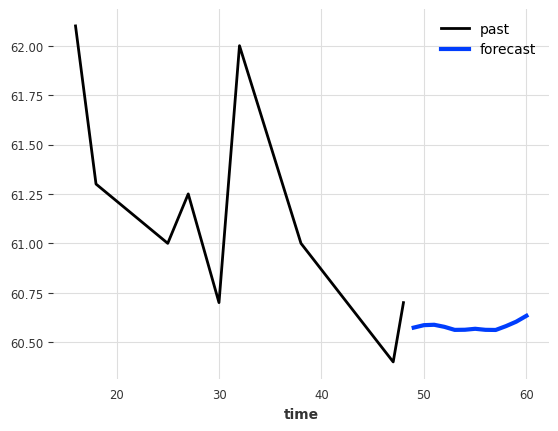

In [206]:
i = np.random.randint(0, len(target))
masked_biometrics_timeseries[i].plot(label='past')
unnorm_preds[i].plot(label='forecast', lw=3)
plt.legend()
plt.show()

Save model and data preprocessor

In [207]:
model.save("weight_model.pkl")

In [208]:
pickle.dump(preprocess_pipeline, open('weight_preprocessor.pkl', 'wb'))

In [209]:
pickle.dump(exercise_scaler, open('weight_scaler.pkl', 'wb'))

# Explainability

In [210]:
from darts.explainability.shap_explainer import ShapExplainer

In [211]:
shap_explainer = ShapExplainer(model, target, past_cov)

In [212]:
WEEKS_PER_MONTH = 4.2

In [303]:
horizons = [int(np.ceil(WEEKS_PER_MONTH * i)) for i in range(1, 6)]

In [319]:
def get_shap_values(shap_explainer, target, past_cov, horizons):
    
    explainability_res = shap_explainer.explain(target, past_cov,  horizons=horizons)
    comp_list = explainability_res.get_feature_values(horizons[0]).components.to_list()
    drop_comp_list = set([x for x in comp_list if any([x.startswith(y) for y in explainability_res.available_components])])

    importances_df = pd.DataFrame([])
    for horizon in horizons:
        if len(importances_df) == 0:
            importances_df = explainability_res.get_explanation(horizon).pd_dataframe().iloc[-1].T
        else:
            importances_df = pd.concat([importances_df, explainability_res.get_explanation(horizon).pd_dataframe().iloc[-1]], axis=1)
            
    importances_df.columns = horizons

    if isinstance(importances_df, pd.Series):
        importances_df = importances_df.to_frame()
        importances_df.columns = [horizons[0]]
    importances_df.reset_index(inplace=True)
    importances_df = importances_df[~importances_df['component'].isin(drop_comp_list)]

    importances_df = importances_df.T
    importances_df.columns = importances_df.iloc[0]
    importances_df = importances_df.drop(importances_df.index[0])
    importances_df.columns.name = 'Horizon'

    lag_columns = [col for col in importances_df.columns if 'lag-' in col]
    prefixes = set(col.rsplit('_', 1)[0] for col in lag_columns)

    for prefix in prefixes:
        lag_cols = [col for col in lag_columns if col.startswith(prefix)]
        importances_df[f'{prefix}'] = importances_df[lag_cols].mean(axis=1)
        
    importances_df = importances_df.drop(columns=lag_columns)
    return importances_df

In [321]:
%%capture
importances_df = get_shap_values(shap_explainer, target[0], past_cov[0], horizons)

In [322]:
importances_df.to_dict()

{'Gender_statcov_target_Weight': {5: -0.00020518779754637637,
  9: -0.0003621368855237043,
  13: -0.000874854400753855,
  17: -0.0018629792332648016,
  21: -0.0029905840754509416},
 'Age_statcov_target_Weight': {5: 8.248949874541574e-05,
  9: 0.0004236141881684974,
  13: 0.000831257134639977,
  17: 0.0012102274228464511,
  21: 0.00146166822785961},
 'avg_cardio_workouts_pastcov': {5: 0.0002550502181402317,
  9: 0.00046180982215829027,
  13: 0.0006906463620146697,
  17: 0.0007973137922115711,
  21: 0.0008509604004261546},
 'cardio_minutes_week_pastcov': {5: 0.00014954988213285636,
  9: -0.0007071200886091811,
  13: -0.0013672042513559962,
  17: -0.000677391161037254,
  21: -0.001015928853611804},
 'avg_calories_per_workout_pastcov': {5: -0.0005582155114234076,
  9: -0.001270982371543451,
  13: -0.0018061596886555324,
  17: -0.0016726820065734573,
  21: -0.0010200620458762847},
 'total_minutes_week_pastcov': {5: 0.00041803567448426036,
  9: 0.000912578088668872,
  13: 0.00121915106566124

In [310]:
importances_df

Index([5, 9, 13, 17, 21], dtype='object')

In [308]:
importances_df.set_index('Feature')['SHAP Value'].to_dict()

{'Gender_statcov_target_Weight': {5: -0.00020518779754633934,
  9: -0.0003621368855237413,
  13: -0.000874854400753892,
  17: -0.0018629792332649127,
  21: -0.0029905840754508675},
 'Age_statcov_target_Weight': {5: 8.248949874511968e-05,
  9: 0.0004236141881686084,
  13: 0.0008312571346386818,
  17: 0.001210227422845082,
  21: 0.00146166822785924},
 'avg_cardio_workouts_pastcov': {5: 0.000255050218993364,
  9: 0.00046180982476355203,
  13: 0.0006906463655469553,
  17: 0.000797313795244133,
  21: 0.0008509604015413982},
 'cardio_minutes_week_pastcov': {5: 0.00014954988213276998,
  9: -0.000707120088609983,
  13: -0.0013672042513563538,
  17: -0.0006773911610369702,
  21: -0.0010159288536117177},
 'avg_calories_per_workout_pastcov': {5: -0.000558215511404546,
  9: -0.0012709823715768812,
  13: -0.0018061596887164715,
  17: -0.0016726820066113774,
  21: -0.0010200620460076735},
 'total_minutes_week_pastcov': {5: 0.00041803567404895427,
  9: 0.0009125780873829622,
  13: 0.00121915106392602

In [285]:
importances_df = importances_df.T.reset_index()
importances_df.columns = ['Feature', 'SHAP Value']

In [290]:
importances_df.columns = ['Feature', 'SHAP Value']

In [295]:
importances_df.sort_values('SHAP Value', ascending=False).reset_index(drop=True)

,Feature,SHAP Value
0,Age_statcov_target_Weight,0.00121
1,avg_duration_per_workout_pastcov,0.001146
2,avg_cardio_workouts_pastcov,0.000797
3,avg_metsmin_workout_pastcov,0.000717
4,total_minutes_week_pastcov,0.00053
5,total_calories_week_pastcov,0.000227
6,isotonic_minutes_week_pastcov,0.000195
7,avg_isotonic_workouts_pastcov,0.000155
8,isotonic_calories_week_pastcov,-0.000089
9,cardio_calories_week_pastcov,-0.00056


In [296]:
# convert to a dictionary with keys in column 'Feature' and values in column 'SHAP Value'
importances_dict = importances_df.set_index('Feature')['SHAP Value'].to_dict()

In [297]:
importances_dict

{'Age_statcov_target_Weight': 0.0012102274228464143,
 'avg_duration_per_workout_pastcov': 0.0011462667651565006,
 'avg_cardio_workouts_pastcov': 0.0007973137952241613,
 'avg_metsmin_workout_pastcov': 0.00071652996010205,
 'total_minutes_week_pastcov': 0.0005302109509473209,
 'total_calories_week_pastcov': 0.0002270850779499339,
 'isotonic_minutes_week_pastcov': 0.0001953380578777475,
 'avg_isotonic_workouts_pastcov': 0.0001549172974570665,
 'isotonic_calories_week_pastcov': -8.87974537921505e-05,
 'cardio_calories_week_pastcov': -0.0005596718674667243,
 'cardio_minutes_week_pastcov': -0.0006773911610370072,
 'avg_calories_per_workout_pastcov': -0.0016726820096053527,
 'Gender_statcov_target_Weight': -0.0018629792332076993}

# Inference

In [6]:
model = RegressionModel.load("weight_model.pkl")
preprocess_pipeline = pickle.load(open('weight_preprocessor.pkl', 'rb'))
scaler = pickle.load(open('weight_scaler.pkl', 'rb'))

In [90]:
def create_bm_timeseries(row):
    times = pd.Index(row[('Biometrics', 'Week')])
    values = row[('Biometrics', 'Value')]
    covs = pd.DataFrame(data={ 'Gender': [row[('Gender', '')]], 'Age': [row[('Age', '')]] })
    ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[row[('Biometrics', 'Name')]], static_covariates=covs, freq=1)
    filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)
    return filled_ts

def create_ex_timeseries(row):
    times = pd.Index(row[('Exercise', 'Week')])
    agg_ts = None
    for col in ex_df['Exercise'].columns:
        if col == 'Week':
            continue
        values = row[('Exercise', col)]
        ts = TimeSeries.from_times_and_values(times=times, values=values, columns=[col], freq=1)
        ts = darts_fill_na(ts, fill=0.).astype(np.float32)
        if agg_ts is None:
            agg_ts = ts
        else:
            agg_ts = agg_ts.stack(ts)
    return agg_ts

In [91]:
ts_df = pd.read_pickle('processed_dataset.pkl')
ex_df = ts_df[['CloudId', 'Exercise']].drop_duplicates(subset=('CloudId', ''))
bm_df = ts_df[['CloudId', 'Gender', 'Age', 'Biometrics']]

cloud_ids = np.intersect1d(ex_df.CloudId.unique(), bm_df.CloudId.unique())

In [ ]:
# Use samples from the dataset
weeks = sliced_train_set[i].time_index
values = sliced_train_set[i].values()
covs = sliced_train_set[i].static_covariates

# # Use your own values
# weeks = pd.Index([0,4,10,16,21,24,26])
# values = [82, 84, 85, 82, 84, 86, 87][::-1]
# covs = pd.DataFrame(data={'Gender': ['M'], 'Age': [30]})

In [ ]:
ts = TimeSeries.from_times_and_values(times=weeks, values=values, static_covariates=covs, freq=1)
filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)

trans_ts = preprocess_pipeline.transform(filled_ts)
pred = model.predict(24, [trans_ts])
unnorm_pred = preprocess_pipeline.inverse_transform(pred)[0]

filled_ts.plot(label='past data')
unnorm_pred.plot(label='forecast', lw=3)
plt.xlabel('Week')
plt.ylabel('Weight')
plt.show()

# Get a user's data

In [109]:
processed_dataset = pd.read_pickle('processed_dataset.pkl')
valid_cloud_ids = processed_biometrics.CloudId.unique()

In [110]:
ex_df = processed_dataset[['CloudId', 'Exercise']].drop_duplicates(subset=('CloudId', ''))
bm_df = processed_dataset[['CloudId', 'Gender', 'Age', 'Biometrics']]

In [105]:
targets = ['Weight', 'Fat mass Perc', 'Muscle Mass', 'HR at Rest']

In [127]:
i = np.random.randint(0, len(valid_cloud_ids))
cloud_id = valid_cloud_ids[i]

In [128]:
user_bms = bm_df[(bm_df.CloudId == cloud_id) & (bm_df[('Biometrics', 'Name')].isin(targets))]
user_bms

CloudId Gender Age     Biometrics  \
                                                                     Name   
15305  cf34daf8525b43b65036f3db587fd2fce61eb8a2      F  58  Fat mass Perc   
15319  cf34daf8525b43b65036f3db587fd2fce61eb8a2      F  58    Muscle Mass   
15338  cf34daf8525b43b65036f3db587fd2fce61eb8a2      F  58         Weight   

                                                   
                   Week                     Value  
15305  [20, 25, 34, 46]  [35.5, 35.9, 34.4, 33.3]  
15319  [20, 25, 34, 46]  [41.3, 40.9, 42.0, 43.2]  
15338  [20, 25, 34, 46]  [67.4, 67.2, 67.5, 68.2]

In [129]:
user_ex = ex_df[(ex_df.CloudId == cloud_id)]
user_ex

CloudId  \
                                                  
15296  cf34daf8525b43b65036f3db587fd2fce61eb8a2   

                                                Exercise  \
                                                    Week   
15296  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...   

                                                          \
                                     total_calories_week   
15296  [911.0, 860.0, 1327.0, 1166.0, 1249.0, 1276.0,...   

                                                          \
                                      total_minutes_week   
15296  [5803, 6549, 8463, 7750, 7787, 7264, 6065, 516...   

                                                          \
                                    cardio_calories_week   
15296  [911.0, 860.0, 1327.0, 1166.0, 1249.0, 1276.0,...   

                                                          \
                                     cardio_minutes_week   
15296  [5803.0, 6549.0, 8463.0, 7750.0, 7787.0, 7264....   

                                                          \
                                  isotonic_calories_week   
15296  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                          \
                                   isotonic_minutes_week   
15296  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                          \
                                avg_duration_per_workout   
15296  [1934.3333333333333, 2183.0, 2115.75, 2583.333...   

                                                          \
                                avg_calories_per_workout   
15296  [303.6666666666667, 286.6666666666667, 331.75,...   

                                                          \
                                     avg_metsmin_workout   
15296  [90.26666666666665, 188.1, 73.775, 181.9666666...   

                                                          \
                                   avg_isotonic_workouts   
15296  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                          
                                     avg_cardio_workouts  
15296  [5.0, 6.0, 6.0, 6.0, 5.0, 3.0, 3.0, 3.0, 7.0, ...

In [131]:
user_ex['Exercise'].iloc[0].to_json()

'{"Week":[15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52],"total_calories_week":[911.0,860.0,1327.0,1166.0,1249.0,1276.0,1027.0,932.0,1797.0,1678.0,1727.0,1598.0,1652.0,1682.0,1553.0,1863.0,1869.0,1742.0,2421.0,1685.0,1564.0,2110.0,2101.0,1698.0,1303.0,1935.0,1510.0,1878.0,1400.0,1519.0,1372.0,1418.0,987.0,1191.0,1814.0,878.0,981.0],"total_minutes_week":[5803,6549,8463,7750,7787,7264,6065,5160,11040,9663,9544,9246,9848,9826,9249,10810,10512,9955,14142,10173,9152,11346,11944,10108,8030,11226,8228,10331,8592,9220,8974,9382,6534,8436,13343,6366,6645],"cardio_calories_week":[911.0,860.0,1327.0,1166.0,1249.0,1276.0,1027.0,932.0,1797.0,1678.0,1727.0,1598.0,1652.0,1682.0,1553.0,1863.0,1869.0,1742.0,2421.0,1685.0,1564.0,2110.0,2101.0,1698.0,1303.0,1935.0,1510.0,1878.0,1400.0,1508.0,1239.0,1176.0,856.0,956.0,1438.0,754.0,819.0],"cardio_minutes_week":[5803.0,6549.0,8463.0,7750.0,7787.0,7264.0,6065.0,5160.0,11040.0,9663.0,9544.0,9246

In [86]:
user_gender = user_bms_filtered['Gender'].iloc[0]
user_age = user_bms_filtered['Age'].iloc[0]

biometric_data_list = user_bms_filtered.drop(['Gender', 'Age'], axis=1).to_dict(orient='records')

In [91]:
biometric_data_list

[{'BiometricName': 'Fat mass Perc',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [40.2, 38.3, 40.6, 39.0]},
 {'BiometricName': 'Muscle Mass',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [53.4, 54.9, 51.7, 53.3]},
 {'BiometricName': 'Weight',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [94.0, 93.7, 91.7, 92.0]}]